<a href="https://colab.research.google.com/github/Manjunath-Yelipeta/EIP_Phase2/blob/master/EIP2_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the required libraries


In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [2]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-9wlbfzdh
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-9wlbfzdh
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-gexmguvt/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 5
data_augmentation = True
num_classes = 10

In [0]:
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

In [6]:


# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


### Importing imagenet pretrained Resnet18 Model

In [8]:
from classification_models.resnet import ResNet18, preprocess_input

model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top = False)

W0713 10:38:08.761359 140506181887872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 10:38:08.823304 140506181887872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 10:38:08.824507 140506181887872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0713 10:38:08.826284 140506181887872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0713 10:38:08.828411 140506

44924928/44920640 [==============================] - 1s 0us/step


In [0]:
from keras.layers import GlobalAveragePooling2D

### Modifying the architecture of pretrained model a bit to suit for Cifar-10 dataset

In [0]:
def build_finetune_model(base_model, num_classes):
    #for layer in base_model.layers:
        #layer.trainable = False
    last_conv_layer = base_model.get_layer("stage2_unit1_relu1")
    x = last_conv_layer.output
    x = Conv2D(10, 1,strides=1,data_format='channels_last',use_bias=False)(x)
    x = GlobalAveragePooling2D()(x)
    #x = Flatten()(x)
   
    # New softmax layer
    predictions = Activation('softmax')(x)
    #Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [0]:

  
finetune_model = build_finetune_model(model, num_classes=10)

## Compiling the Model

In [13]:
finetune_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
finetune_model.summary()

W0713 10:39:00.316582 140506181887872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
_______________________________________________________________________________________

In [14]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 4.9MB/s 


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [16]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
filepath="./cifar10_resnet_pretrained-model.{epoch:03d}.hdf5"

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [70]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,data_format='channels_last')
# Train the model
model_info = finetune_model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 10, 
                                 validation_data = (x_test, y_test), verbose=1,callbacks = callbacks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=10)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarni

Epoch 1/10
Learning rate:  0.001
390/390 [==============================] - 206s 529ms/step - loss: 0.3246 - acc: 0.8874 - val_loss: 0.7799 - val_acc: 0.7512

Epoch 00001: val_acc did not improve from 0.75580
Epoch 2/10
Learning rate:  0.001
390/390 [==============================] - 205s 524ms/step - loss: 0.3014 - acc: 0.8961 - val_loss: 0.8560 - val_acc: 0.7498

Epoch 00002: val_acc did not improve from 0.75580
Epoch 3/10
Learning rate:  0.001
390/390 [==============================] - 204s 524ms/step - loss: 0.2784 - acc: 0.9032 - val_loss: 0.8507 - val_acc: 0.7469

Epoch 00003: val_acc did not improve from 0.75580
Epoch 4/10
Learning rate:  0.001
390/390 [==============================] - 204s 522ms/step - loss: 0.2529 - acc: 0.9114 - val_loss: 0.9389 - val_acc: 0.7339

Epoch 00004: val_acc did not improve from 0.75580
Epoch 5/10
Learning rate:  0.001
390/390 [==============================] - 203s 520ms/step - loss: 0.2325 - acc: 0.9203 - val_loss: 0.8280 - val_acc: 0.7637

Epoch

### Copying the trained Best model from google colab to google drive

In [0]:
!cp  "./cifar10_resnet_pretrained-model.006.hdf5"  "/content/gdrive/My Drive/cifar10_resnet_pretrained-model.006.hdf5"

In [19]:
!ls /content/gdrive/

'My Drive'


In [0]:
! cp "/content/gdrive/My Drive/cifar10_resnet_pretrained-model.006.hdf5" "./cifar10_resnet_pretrained-model.006.hdf5"

In [0]:
finetune_model.load_weights( "./cifar10_resnet_pretrained-model.006.hdf5")

In [0]:
# Use separate Preprocessor for Test/Validation data
datagen_validator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,)
datagen_validator.fit(x_train)

### Getting the predictions on the Validation dataset without Shuffling

In [0]:
iterator = datagen_validator.flow(x_test, y_test, batch_size=1024, shuffle=False)
predictions = finetune_model.predict_generator(iterator,steps=len(iterator))

### Getting the first 50 misclassified Images

In [0]:
def get_misclassified(X, Y_ohe, Y_pred, total=50,pick_randomly=False):
  y_true = np.argmax(Y_ohe, axis=1)
  yp = np.argmax(Y_pred, axis=1)
  misclassified = y_true != yp
  X = X[misclassified]
  Y_ohe = Y_ohe[misclassified]
  Y_pred = Y_pred[misclassified]
  y_true = y_true[misclassified]
  yp = yp[misclassified]
  total = min(total, len(X))

  indexes = np.random.choice(len(X), total, replace=False) if pick_randomly else list(range(0, total))

  X = np.take(X, indexes, axis=0)
  Y_ohe = np.take(Y_ohe, indexes, axis=0)
  Y_pred = np.take(Y_pred, indexes, axis=0)
  y_true = np.take(y_true, indexes, axis=0)
  yp = np.take(yp, indexes, axis=0)
  return (X,Y_ohe, y_true,yp)


In [0]:
x_misclassifed,y_ohe,y_true,y_pred_misclassified = get_misclassified(x_test, y_test, predictions[:len(y_test)], total=50,pick_randomly=False)

### Checking if we got required 50 misclassified images

In [22]:
print(*(zip(y_true,y_pred_misclassified)))

(8, 3) (8, 3) (0, 3) (6, 3) (6, 3) (1, 3) (6, 3) (1, 3) (0, 3) (9, 3) (5, 3) (7, 3) (9, 3) (8, 3) (5, 3) (7, 3) (8, 3) (6, 3) (7, 3) (0, 3) (4, 3) (9, 3) (5, 3) (2, 3) (4, 3) (0, 3) (9, 3) (6, 3) (6, 3) (5, 3) (4, 3) (5, 3) (9, 3) (2, 3) (4, 3) (1, 3) (9, 3) (5, 3) (4, 3) (6, 3) (5, 3) (6, 3) (0, 3) (9, 3) (9, 3) (7, 3) (6, 3) (9, 3) (8, 3) (0, 3)


In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, accuracy_score
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, AveragePooling2D
from keras.layers import Input, concatenate
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, SpatialDropout2D, Add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
#from keras_contrib.callbacks import CyclicLR
from keras.models import Model
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import random
#from data_science_utils.vision.keras import *
#from data_science_utils import misc
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.gridspec as gridspec

#from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

#from keras.applications.xception import Xception, preprocess_input as ppix, decode_predictions


from keras.preprocessing import image
import numpy as np
import cv2

import gc

In [0]:
def gradcam(model,layer,img,class_idx,preprocess_func=None,
            show=False):
  
  x = np.expand_dims(image.img_to_array(img), axis=0)
  img = np.copy(img)
  class_idx = np.argmax(class_idx, axis=0) if type(class_idx)==list or type(class_idx)==np.ndarray else class_idx
  if preprocess_func is not None:
    x = preprocess_func(x)
  #import pdb
  #pdb.set_trace()
  preds = model.predict(x)
  preds = np.argmax(preds, axis=1)[0]
  
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  layer_out_channels = last_conv_layer.output_shape[-1]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(layer_out_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
    
  heatmap = heatmap/255
  for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
      if heatmap[i][j][1]<=0.01 and heatmap[i][j][2]<=0.01:
        heatmap[i][j] = 0
        
  img = (img - np.min(img))/(np.max(img)-np.min(img))
  superimposed_img = 0.65*(img) + 0.35*heatmap
  
  for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
      if np.sum(heatmap[i][j])==0:
        superimposed_img[i][j]=img[i][j]
  
  if show:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    plt.imshow(heatmap)
    plt.axis("off")
    plt.show()
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()
  return img,heatmap,superimposed_img,preds


def show_examples_with_gradcam(model,layer,images,labels,classes=None,preprocess_func=None,image_size_multiplier=3):
  columns = 5
  rows = int(np.ceil(len(images) / columns))
  labels = np.argmax(labels, axis=1) if type(labels[0])==list or type(labels[0])==np.ndarray else labels
  fig_height = rows * image_size_multiplier * 3
  fig_width = columns * image_size_multiplier
  fig = plt.figure(figsize=(fig_width, fig_height))
  outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
  for i in range(rows*columns):
    if i>=len(images):
      break
    x = images[i]
    y = labels[i]
    img,heatmap,superimposed_img,prediction = gradcam(model,layer,x,y,preprocess_func=preprocess_func,show=False)
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                    subplot_spec=outer[i], wspace=0.0, hspace=0.15)
    imgs = [img,heatmap,superimposed_img]
    label = classes[y] if classes is not None else ""
    label = label.split(' ', 1)[0]
    prediction = classes[prediction]
    titles = [("Actual:"+label+" Pred:"+prediction).replace(' ', '\n'),"HeatMap","SuperImposed Image"]
    for j in range(3):
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(imgs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[j])
        fig.add_subplot(ax)
  
  fig.show()
  

In [0]:
def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [32]:
y_true

array([8, 8, 6, 1, 5, 5, 7, 8, 7, 4, 5, 2, 4, 6, 5, 4, 5, 9, 2, 4, 1, 4,
       5, 6, 8, 0, 8, 8, 4, 6, 6, 6, 1, 2, 3, 7, 2, 6, 8, 8, 0, 9, 3, 8,
       8, 2, 5, 7, 8, 8])

In [33]:
y_pred_misclassified

array([0, 9, 0, 9, 3, 9, 1, 9, 0, 1, 9, 3, 3, 0, 3, 1, 3, 0, 3, 7, 9, 0,
       3, 3, 9, 7, 0, 0, 9, 0, 7, 3, 3, 9, 6, 9, 0, 0, 9, 0, 9, 0, 0, 9,
       9, 0, 7, 9, 9, 1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


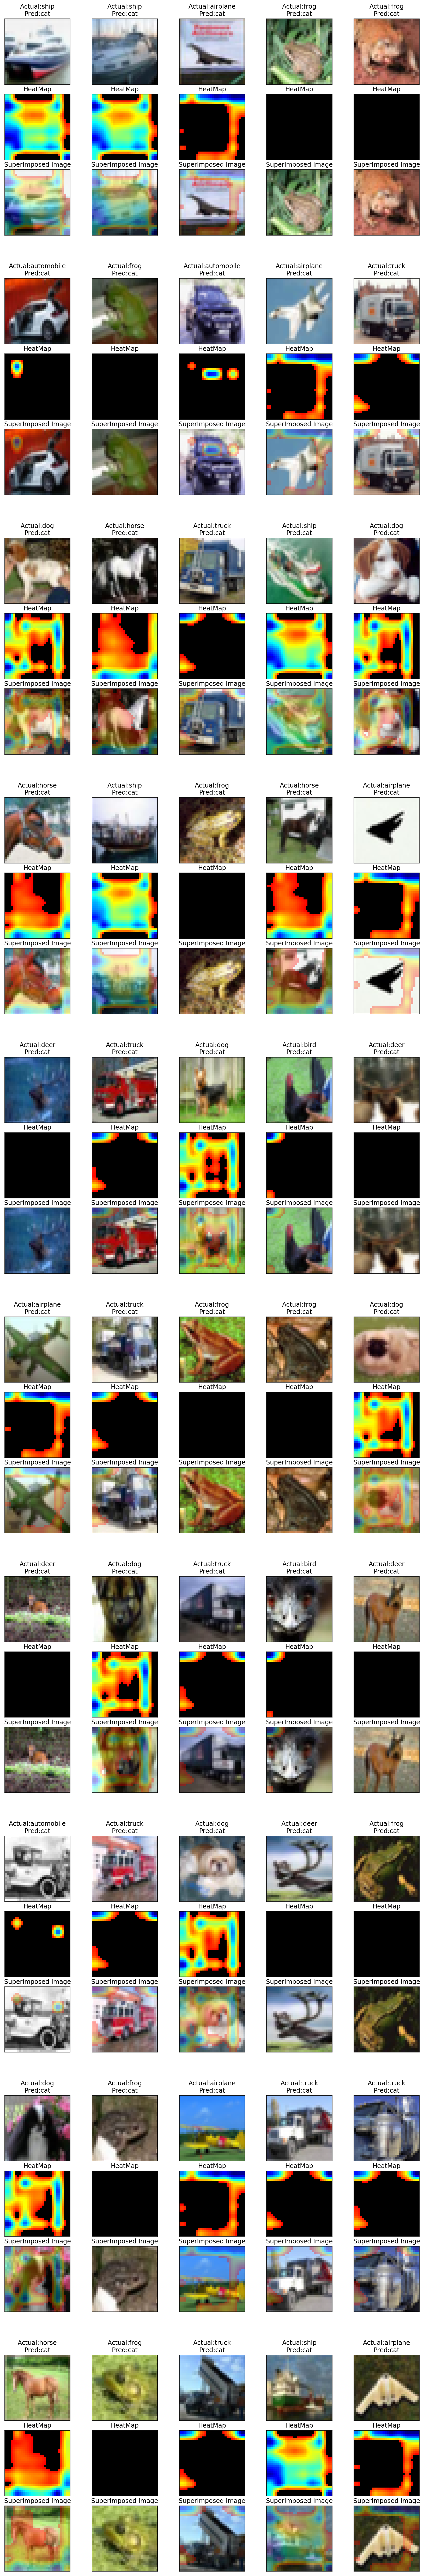

In [29]:
show_examples_with_gradcam(finetune_model,layer="conv2d_1",images=x_misclassifed, labels= y_ohe,
                           classes=get_cifar10_labels())

In [49]:
finetune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch